<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/AAA_scenario_10yr_put.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  2 20:13:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    92W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip3 install torch torchvision --upgrade

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.2.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [3]:
import torch
from torch.autograd import grad
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.2.0
cuda


##Scenario generator
The following block generate the US Diversified equity scenario. It follows the logic from 
Academy's Interest Rate Generator version 7.1.201805 which is download from [Society of Acturies](https://www.soa.org/resources/tables-calcs-tools/research-scenario/)


In [0]:
import math
@torch.jit.script
def aaa_us(N:int=10000, T:int=360, sigma_0:float=0.1476, device:str="cuda"):

  """
    return us equity scenario, following the AAA logic
    N is scenario number, 
    T is the number of month
    sigma_0 is the initial vol, default to AAA US Diversified Equity
    All other parameters below are for US Diversified Equity and
    copied from Academy's Interest Rate Generator (AIRG) (Version 7.1.201805)
  """


  tau = 0.12515
  phi = 0.35229
  sigma_v =0.32645
  rho = -0.2488
  A = 0.055
  B = 0.56
  C = -0.9
  
  sigma_min = 0.0305
  sigma_max = 0.3
  sigma_max2 = 0.7988


  #cholesky decompsition
  corr=torch.eye(2,device=device)
  corr[0,1]=rho
  corr[1,0]=rho
  chl=torch.cholesky(corr)

  #correlated random number
  rdn=torch.randn(N,T,2,1,device=device)
  rdn=torch.matmul(chl,rdn)
  rdn=rdn.view(N,T,2)

  sigma=torch.ones(N,T+1,device=device)
  us=torch.ones(N,T+1,device=device)

  sigma[:,0]=sigma_0
  us[:,0]=1.0

  log_tau=math.log(tau)
  log_sigma_min=math.log(sigma_min)
  log_sigma_max=math.log(sigma_max)
  log_sigma_max2=math.log(sigma_max2)

  sqrt12=math.sqrt(12.0)
  for t in range(T):
    log_vol=torch.log(sigma[:,t])
    log_vol=(1-phi)*log_vol+phi*log_tau
    log_vol=torch.clamp(log_vol,max=log_sigma_max)
    log_vol=log_vol+rdn[:,t,0]*sigma_v
    log_vol=torch.clamp(log_vol,min=log_sigma_min,max=log_sigma_max2)
    sigma[:,t+1]=torch.exp(log_vol)
    mean_return=A+B*sigma[:,t+1]+C*sigma[:,t+1]*sigma[:,t+1]
    next_return=mean_return/12.0+rdn[:,t,1]*sigma[:,t+1]/sqrt12
    us[:,t+1]=us[:,t]*torch.exp(next_return)
  return us, sigma

10 year point from original excel model 
avg ln=0.732818079,std ln=0.479882024
10 year point from pytorch model
avg ln= 0.7351230978965759 std ln= 0.48336073756217957
30 year point from original excel 
avg ln=2.196974867,std ln=0.825873276
30 year point from pytorch model
avg ln= 2.1949477195739746 std ln= 0.8230361342430115


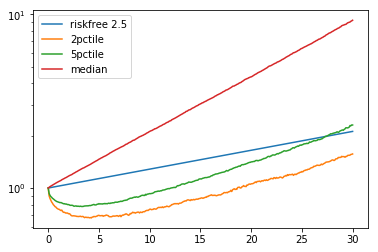

In [20]:
us, sigma = aaa_us()
log120=torch.log(us[:,120])
log360=torch.log(us[:,360])
print("10 year point from original excel model \navg ln=0.732818079,std ln=0.479882024")
print("10 year point from pytorch model")
print("avg ln=",log120.mean().item(),"std ln=",log120.std().item())
print("30 year point from original excel \navg ln=2.196974867,std ln=0.825873276")
print("30 year point from pytorch model")
print("avg ln=",log360.mean().item(),"std ln=",log360.std().item())

import matplotlib.pyplot as plt
import numpy as np
us=us.to('cpu').numpy()
pct2=np.percentile(us,2,axis=0)
pct5=np.percentile(us,5,axis=0)
pct50=np.percentile(us,50,axis=0)

t2=torch.linspace(0,30,361).cpu().numpy()
rf2=np.exp(.025*t2)
plt.plot(t2,rf2,label='riskfree 2.5')
plt.plot(t2,pct2,label='2pctile')
plt.plot(t2,pct5,label='5pctile')
plt.plot(t2,pct50,label='median')


plt.yscale('log')
plt.legend()
plt.show()


### Liability cashflow

The liability is a 25 year put with strike at 3.0

In [0]:
def cashflow_1(scenario):
  """
    cash flow module for a put
  """
  strike = 3.
  payout = torch.clamp(strike-scenario[:,-1],min=0.0)
  cf=torch.zeros_like(scenario)
  cf[:,-1].add_(payout)
  return cf


Generate scenario and cashflow

In [0]:
K1, K2 = 6, 10
N1=2**K1   #batch count
N2=2**K2   #batch size

T=300
rf=0.025

idx,sigma=aaa_us(N=N1*N2,T=T)

cf=cashflow_1(idx)

idx=idx.view(N1,N2,T+1)
sigma=sigma.view(N1,N2,T+1)
cf=cf.view(N1,N2,T+1)

t=torch.linspace(0,T/12,T+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)

pv_payout=cf[:,:,-1]*disc[:,:,-1]

#the chg is discounted to time zero already
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]

# chg2 is the second order discounted to time zero    
chg2=torch.log(idx[:,:,1:]/idx[:,:,:-1])**2-((sigma[:,:,1:])**2)/12
chg2=chg2*disc[:,:,1:]

Manipulate data to feed to the neural network. 

In [0]:
t=torch.linspace(T/12,1/12,T,device=device)  #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,T,1)
s.requires_grad=True
v=sigma[:,:,:-1].view(N1,N2,T,1)
t=t.view(N1,N2,T,1)
tsv=torch.cat((t,s,v),3)

The neural network. we have three input: time to maturity, index level and the short term volatility from AAA scenario generator

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

The time step for AAA scenario is monthly. It is not sufficient for delta hedge. We use the gamma and expected volatility to approximate the result of daily rebalancing delta hedge. 

In [10]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.02,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()
for t in range(300):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-model_delta(tsvi)

        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=hedged_price.std()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
    t2=time.time()
    if t2-t1> 180:
      break
print(t2-t1)      

0 0.21863597631454468
10 0.0373508520424366
20 0.036389488726854324
30 0.035424456000328064
40 0.03477509692311287
50 0.03432275354862213
60 0.03408924490213394
181.14356970787048


In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

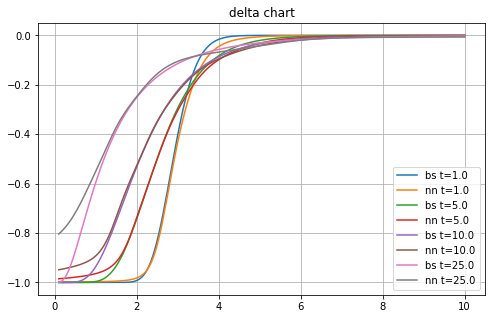

In [12]:
import matplotlib.pyplot as plt
import numpy as np

vol=torch.log(idx[:,:,-1]).std().cpu().item()
vol=vol/math.sqrt(25) 
#this is the effective volatility of the scenario at year 25

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[1.0,5.0,10.0,25.0]
for t in tl:
  s=torch.linspace(0.1,10,200,device=device)
  tsvc=torch.zeros((200,3),device=device)
  tsvc[:,0]=t
  tsvc[:,1]=s
  tsvc[:,2]= 0.1476
  d_bs=delta_bs(s.cpu().numpy(),3.,rf,0,t,vol)-1
  d_nn=-model_delta(tsvc)
  plt.plot(s.cpu().numpy(),d_bs,label="bs t="+ "%.1f" % t)
  plt.plot(s.cpu().numpy(),d_nn.cpu().view(200).detach().numpy(),
           label="nn t="+ "%.1f" % t)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()

The delta chart from the delta neural network actually matches up with the Black-Scholes delta relatively well. The volatility assumption for the Black-Scholes delta is based on the variance of log(index_25) distribution. At lower strike, the neural network tend to have slight smaller(more positive) delta. This is consistent with how AAA equity scenario is calibrated. The skew of the distribution is negative, which means the expected volatility of the remaining life of the put will be higher if the index is lower. And higher volatility leads to smaller delta.

In [0]:
def cte98(e):
  n=e.size()[0]
  k=math.ceil(n*0.02)
  l2=e.topk(k,sorted=False).values.mean()
  return l2

def cte70(e):
  n=e.size()[0]
  k=math.ceil(n*0.3)
  l2=e.topk(k,sorted=False).values.mean()
  return l2  

In [14]:
delta=model_delta(tsv)
delta=-delta.view(N1,N2,T)

g = torch.ones_like(delta)
gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)      

gamma=gamma[:,:,:,1].view(N1,N2,T)
delta_gl=torch.sum(delta*chg,dim=2)
gamma_gl=torch.sum(gamma*chg2,dim=2)

pre_hedge=pv_payout.std().item()
post_hedge=(delta_gl+gamma_gl-pv_payout).std().item()

print("\n% scenario with payout: ",pv_payout.sign().mean().item())

print("\nstd pv payout, after hedge, effectiveness")
print("{:.2%}".format(pre_hedge), "{:.2%}".format(post_hedge), \
      "{:.2%}".format(1-post_hedge/pre_hedge))

print("\nAverage, before and after hedge:")
print(pv_payout.mean().item())
print((pv_payout-gamma_gl-delta_gl).mean().item())

print("\nCTE 70, before and after hedge:")
print(cte70(pv_payout).item())
print(cte70(pv_payout-gamma_gl-delta_gl).item())

print("\nCTE 98, before and after hedge:")
print(cte98(pv_payout).item())
print(cte98(pv_payout-gamma_gl-delta_gl).item())


% scenario with payout:  0.1699676513671875

std pv payout, after hedge, effectiveness
23.07% 3.50% 84.84%

Average, before and after hedge:
0.08367037773132324
0.7451170086860657

CTE 70, before and after hedge:
1.1032941341400146
0.8583694696426392

CTE 98, before and after hedge:
1.3319491147994995
0.9296748638153076


The hedge effectiveness is around 85%. CTE actually improved from 1.33 to around 0.93. the improvement 

### Add CTE98 as training target

In [0]:
cte_delta = torch.nn.Sequential(
    torch.nn.Linear(3, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32,8),
    torch.nn.Tanh(),
    torch.nn.Linear(8, 1),
    torch.nn.Sigmoid(),
)
cte_delta = cte_delta.to(device)

First train the network with the std target for a little bit. Then shift to the CTE 98 target

In [16]:
import time
optimizer = torch.optim.AdamW(cte_delta.parameters(),lr=0.02,
                              weight_decay=1e-10,amsgrad=True)
t1=time.time()

for t in range(10):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-cte_delta(tsvi)

        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=hedged_price.std()
        loss.backward()
        optimizer.step()    
        
optimizer = torch.optim.AdamW(cte_delta.parameters(),lr=0.02,
                              weight_decay=1e-10,amsgrad=True)
for t in range(300):
    for i in range(N1):
        optimizer.zero_grad()
        tsvi=tsv[i]
        delta=-cte_delta(tsvi)

        g = torch.ones_like(delta)
        gamma, =grad(delta,tsvi,grad_outputs=g,create_graph=True)   

        delta=delta.view(N2,T)
        gamma=gamma[:,:,1].view(N2,T)
        delta_gl=torch.sum(delta*chg[i],dim=1)
        gamma_gl=torch.sum(gamma*chg2[i],dim=1)

        hedged_price=pv_payout[i]-delta_gl-gamma_gl
      
        loss=cte98(hedged_price) #+hedged_price.std()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
    t2=time.time()
    if t2-t1> 180:
      print(t2-t1)
      break

0 0.8341349959373474
10 0.8095418214797974
20 0.798590898513794
30 0.8004111647605896
40 0.7934030294418335
50 0.7947037220001221
182.12424111366272


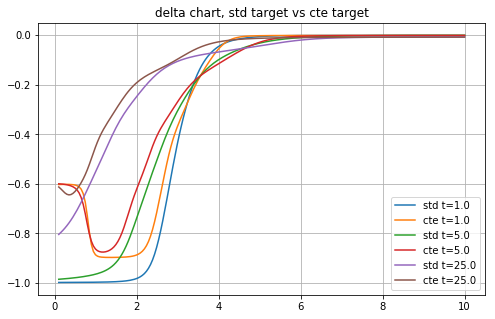

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[1,5.0,25.0]
for t in tl:
  s=torch.linspace(0.1,10,200,device=device)
  tsvc=torch.zeros((200,3),device=device)
  tsvc[:,0]=t
  tsvc[:,1]=s
  tsvc[:,2]= 0.1476
  d_cte=-cte_delta(tsvc)
  d_nn=-model_delta(tsvc)

  plt.plot(s.cpu().numpy(),d_nn.cpu().view(200).detach().numpy(),
           label="std t="+ "%.1f" % t)

  plt.plot(s.cpu().numpy(),d_cte.cpu().view(200).detach().numpy(),
           label="cte t="+ "%.1f" % t)


plt.title("delta chart, std target vs cte target")
plt.legend()
#plt.savefig("test.svg")
plt.show()

After using cte as traning target, the delta is smaller(more positive) compared to previous model. This is to take advantage of the build in upward drift of the AAA scenario. It's interesting tjat the slope of delta curve(gamma) would change direction for very low index levels. 

In [18]:
delta=cte_delta(tsv)
delta=-delta.view(N1,N2,T)

g = torch.ones_like(delta)
gamma, =grad(delta,tsv,grad_outputs=g,create_graph=True)      

gamma=gamma[:,:,:,1].view(N1,N2,T)
delta_gl=torch.sum(delta*chg,dim=2)
gamma_gl=torch.sum(gamma*chg2,dim=2)

pre_hedge=pv_payout.std().item()
post_hedge=(delta_gl+gamma_gl-pv_payout).std().item()

print("\n% scenario with payout: ",pv_payout.sign().mean().item())

print("\nstd pv payout, after hedge, effectiveness")
print("{:.2%}".format(pre_hedge), "{:.2%}".format(post_hedge), \
      "{:.2%}".format(1-post_hedge/pre_hedge))

print("\nAverage, before and after hedge:")
print(pv_payout.mean().item())
print((pv_payout-gamma_gl-delta_gl).mean().item())

print("\nCTE 70, before and after hedge:")
print(cte70(pv_payout).item())
print(cte70(pv_payout-gamma_gl-delta_gl).item())

print("\nCTE 98, before and after hedge:")
print(cte98(pv_payout).item())
print(cte98(pv_payout-gamma_gl-delta_gl).item())


% scenario with payout:  0.1699676513671875

std pv payout, after hedge, effectiveness
23.07% 5.45% 76.39%

Average, before and after hedge:
0.08367037773132324
0.6335208415985107

CTE 70, before and after hedge:
1.1032941341400146
0.8044309616088867

CTE 98, before and after hedge:
1.3319491147994995
0.8724246025085449


The CTE further improved from 0.93 to 0.87